In [1]:
###성공###
import sys
sys.path.append('/home/lgm/JEONGHO/RL스터디2020/')
import tensorflow as tf
import numpy as np
import gym
import dobroEnv
import random
from collections import deque

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

# from halfCheetah import HalfCheetah

/home/lgm/JEONGHO/ATARI/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lgm/JEONGHO/ATARI/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lgm/JEONGHO/ATARI/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lgm/JEONGHO/ATARI/lib/python3.5/site-packages/tensorflow/python/framework

In [2]:
# env = gym.make('DobroHalfCheetah-v0')
# env.unwrapped.initialize(is_render=True) # renderin하려면.
GAME_NAME = 'Pendulum-v0'

env = gym.make(GAME_NAME)
eval_env = gym.make(GAME_NAME)

MAX_EPISODE =100
REPLAY_BUFFER_SIZE = 10000
BATCH_SIZE = 128
GAMMA = 0.99
ALPHA = 0.1
BETA = 0.1
SOFT_UPDATA_TAU = 0.001
STATE_DIM = env.observation_space.shape[0]
ACTION_DIM = env.action_space.shape[0]
Policy_LR = 3e-4
Qnet_LR = 3e-4
MIN_REPLAY_SIZE = 1000

In [3]:
class ReplayBuffer():
    def __init__(self, buffer_size):
        self.history = deque([], maxlen = buffer_size)
    def update(self, state, action, reward, next_state, done):
        buffer = (state, action, reward, next_state, done)
        self.history.append(buffer)
        
    def sample_batch(self, batch_size):
        batch = random.sample(self.history, batch_size)
        return batch

In [24]:
class Agent():
    def __init__(self):
        self.replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
        self.gamma = GAMMA
        self.alpha = ALPHA
        self.betha = BETA 
        self.tau = SOFT_UPDATA_TAU
        self.state_dim = STATE_DIM
        self.action_dim = ACTION_DIM
        self.batch_size = BATCH_SIZE
        self.minimum_replay_size = MIN_REPLAY_SIZE
        self.eval_count = 0
        
        self.PolicyOptimizer = tf.train.AdamOptimizer(learning_rate=Policy_LR)
        self.QnetOptimizer = tf.train.AdamOptimizer(learning_rate=Qnet_LR)
        
        with tf.variable_scope('SACagent'):
            self.state_ph = tf.placeholder(tf.float32, shape=(None, self.state_dim), name='state_ph')
            self.action_ph = tf.placeholder(tf.float32, shape=(None, self.action_dim), name='action_ph')
            self.sample_action_ph = tf.placeholder(tf.float32, shape=(None, self.action_dim), name='sample_action_ph')
            self.action_eps_ph = tf.placeholder(tf.float32, shape=(None,self.action_dim), name='eps_ph')
            self.action_std_ph = tf.placeholder(tf.float32, shape=(None,self.action_dim), name='std_ph')
            
            self._build_policy()
            self._build_qnet()
            
            self.policy_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/policy')

            self.qnet1_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/onlineq1')
            self.qnet2_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/onlineq2')
            self.qnet1_target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/targetq1')
            self.qnet2_target_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/targetq2')
            self.qnet_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'SACagent/onlineq')
            
            self.q1_target_update_ops, self.q2_target_update_ops = self._build_q_target_update_ops()
            

            self.reward_ph = tf.placeholder(tf.float32, (None,1), name='reward_ph')
            self.done_ph = tf.cast(tf.placeholder(tf.bool, (None,1), name='done_ph'), tf.float32)

            
            self.log_policy = - 0.5 * tf.log(1e-8+(2.*np.pi * self.action_std**2)) \
                                    - 0.5 * (self.action_eps_ph)**2 \
                                    - tf.expand_dims(tf.reduce_sum(tf.log(1e-8+1 - tf.square(self.action)),axis=1),1)#sampling된 액션1(from current state of buffer)

            self.log_policy_next = - 0.5 * tf.log(1e-8+(2.*np.pi * self.action_std_ph**2)) \
                                            - 0.5 * (self.action_eps_ph)**2 \
                                            - tf.expand_dims(tf.reduce_sum(tf.log(1e-8+1 - tf.square(self.action_ph)),axis=1),1)#sampling 된 액션2 (from next_state of buffer)
            
            
            self.qnet_target = self.reward_ph + self.gamma * (1 - self.done_ph) * (self.qmin_target - self.alpha * self.log_policy_next) # 전부 샘플링된 액션2 (from next_state of buffer)
            self.qnet_target_ph = tf.placeholder(tf.float32, shape=(None, self.action_dim), name='qnet_target_ph')

            # 폴리시 LOSS
            self.policy_loss = tf.reduce_mean(self.alpha * self.log_policy - self.qmin_backprop)
        
            # q네트워크 LOSS
            self.qnet1_loss = tf.reduce_mean(tf.square(self.q_value1 - self.qnet_target_ph)) # q_value1: buffer's current action, current state
            self.qnet2_loss = tf.reduce_mean(tf.square(self.q_value2 - self.qnet_target_ph)) 
            self.qnet_loss = self.qnet1_loss + self.qnet2_loss

            self.qnet_update = self.QnetOptimizer.minimize(self.qnet_loss, var_list=self.qnet_vars)
            
            self.policy_update = self.PolicyOptimizer.minimize(self.policy_loss, var_list=self.policy_vars)
#         print('HHHHHHHHHHHHHHHHHHHHHHHHHHHHH')
#         self.q_initial_sync()
            
            
            
            
    def _build_qnet(self):
        LAYER_SIZE = 128
        init_mu = 0.
        init_std = 0.1
        qnet_input = tf.concat([self.state_ph, self.action_ph], axis=1)
        with tf.variable_scope('onlineq1'):
            qnet_hid11 = tf.layers.dense(inputs=qnet_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h1')
            qnet_hid11 = tf.nn.relu(qnet_hid11)
            qnet_hid12 = tf.layers.dense(inputs=qnet_hid11, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h2')
            qnet_hid12 = tf.nn.relu(qnet_hid12)

            self.q_value1 = tf.layers.dense(inputs=qnet_hid12, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h3')
        
        with tf.variable_scope('onlineq2'):
            qnet_hid21 = tf.layers.dense(inputs=qnet_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h1')
            qnet_hid21 = tf.nn.relu(qnet_hid21)
            qnet_hid22 = tf.layers.dense(inputs=qnet_hid21, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h2')
            qnet_hid22 = tf.nn.relu(qnet_hid22)

            self.q_value2 = tf.layers.dense(inputs=qnet_hid22, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h3')
        self.qmin = tf.minimum(self.q_value1, self.q_value2)
        
        qnet_target_input = tf.concat([self.state_ph, self.sample_action_ph], axis=1)
        with tf.variable_scope('targetq1'):
            qnet_target_hid11 = tf.layers.dense(inputs=qnet_target_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt1_h1')
            qnet_target_hid11 = tf.nn.relu(qnet_target_hid11)
            qnet_target_hid12 = tf.layers.dense(inputs=qnet_target_hid11, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt1_h2')
            qnet_target_hid12 = tf.nn.relu(qnet_target_hid12)

            self.q_value1_target = tf.layers.dense(inputs=qnet_target_hid12, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt1_h3')
        
        with tf.variable_scope('targetq2'):
            qnet_target_hid21 = tf.layers.dense(inputs=qnet_target_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt2_h1')
            qnet_target_hid21 = tf.nn.relu(qnet_target_hid21)
            qnet_target_hid22 = tf.layers.dense(inputs=qnet_target_hid21, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt2_h2')
            qnet_target_hid22 = tf.nn.relu(qnet_target_hid22)

            self.q_value2_target = tf.layers.dense(inputs=qnet_target_hid22, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='qt2_h3')
        self.qmin_target = tf.minimum(self.q_value1_target, self.q_value2_target)
        
        #### q에 들어가는 action이 self.action이어서 grad가 back prop되는 q들
        qnetg_input = tf.concat([self.state_ph, self.action], axis=1)
        with tf.variable_scope('onlineq1', reuse=True):
            qnetg_hid11 = tf.layers.dense(inputs=qnetg_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h1')
            qnetg_hid11 = tf.nn.relu(qnetg_hid11)
            qnetg_hid12 = tf.layers.dense(inputs=qnetg_hid11, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h2')
            qnetg_hid12 = tf.nn.relu(qnetg_hid12)

            self.q_value1_copy = tf.layers.dense(inputs=qnetg_hid12, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q1_h3')
        with tf.variable_scope('onlineq2', reuse=True):
            qnetg_hid21 = tf.layers.dense(inputs=qnetg_input, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h1')
            qnetg_hid21 = tf.nn.relu(qnetg_hid21)
            qnetg_hid22 = tf.layers.dense(inputs=qnetg_hid21, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h2')
            qnetg_hid22 = tf.nn.relu(qnetg_hid22)

            self.q_value2_copy = tf.layers.dense(inputs=qnetg_hid22, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std),name='q2_h3')
        self.qmin_backprop = tf.minimum(self.q_value1_copy, self.q_value2_copy)
        
    def _build_policy(self):
        LAYER_SIZE = 128
        init_mu = 0.
        init_std = 0.1
        with tf.variable_scope('policy'):
            policy_hid1 = tf.layers.dense(inputs=self.state_ph, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std))
            policy_hid1 = tf.nn.relu(policy_hid1)
            
            policy_hid2 = tf.layers.dense(inputs=policy_hid1, units=LAYER_SIZE, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std))
            policy_hid2 = tf.nn.relu(policy_hid2)
            
            self.action_mu = tf.layers.dense(inputs=policy_hid2, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std))
            self.action_std = tf.layers.dense(inputs=policy_hid2, units=self.action_dim, kernel_initializer=tf.compat.v1.initializers.random_normal(init_mu,init_std), bias_initializer= tf.compat.v1.initializers.random_normal(init_mu,init_std))
            self.action_std = tf.nn.softplus(self.action_std)


            self.unbounded_action = self.action_mu + self.action_std * self.action_eps_ph
            self.action = tf.nn.tanh(self.unbounded_action)



    def q_initial_sync(self):
        ops1 = []
        for target_var, online_var in zip(self.qnet1_target_vars, self.qnet1_vars):
            ops1.append(target_var.assign(online_var))
        ops2 = []
        for target_var, online_var in zip(self.qnet2_target_vars, self.qnet2_vars):
            ops2.append(target_var.assign(online_var))
        for op in ops1:
            sess.run(op)
        for op in ops2:
            sess.run(op)
        print('#########################\nQ net initially sync done\n#########################')
        
    def _build_q_target_update_ops(self):
        ops1 = []
        for target_var, online_var in zip(self.qnet1_target_vars, self.qnet1_vars):
            ops1.append(target_var.assign(self.tau * online_var + (1-self.tau) * target_var))
        ops2 = []
        
        for target_var, online_var in zip(self.qnet2_target_vars, self.qnet2_vars):
            ops2.append(target_var.assign(self.tau * online_var + (1-self.tau) * target_var))
        return ops1, ops2

    
    def q_target_update(self):
        for op in self.q1_target_update_ops:
            sess.run(op)
        for op in self.q2_target_update_ops:
            sess.run(op)
    
        
    def sample_action(self, state, Train=False):
        if Train:
            eps = self.sample_action_eps(Train=True)
            
            action = sess.run(self.action, feed_dict={self.state_ph:state, self.action_eps_ph:eps})

            return action, eps
        else:
            if len(self.replay.history) < self.minimum_replay_size:
                action = [env.action_space.sample()]

                ua = action
            else:
                eps = self.sample_action_eps()
                action, ua = sess.run([self.action,self.unbounded_action], feed_dict={self.state_ph:[state], self.action_eps_ph:[eps]})

            return action, ua
    
    def sample_action_eval(self, state):
#         eps = self.sample_action_eps()
        action = sess.run(self.action_mu, feed_dict={self.state_ph:[state]})
    
        return np.tanh(action)

        
    def sample_action_eps(self, Train=False):
        if Train:
            action_eps = np.random.normal(size=(self.batch_size, self.action_dim))
#             print('예시', action_eps)
        else:
            action_eps = np.random.normal(size=self.action_dim) # shape 아마 틀릴듯
        return action_eps
    
    def sample_batch(self):
        batch = self.replay.sample_batch(self.batch_size)
        return batch
    

        
    
        
    def train_policy(self, states,actions,rewards,next_states,dones):

        eps = self.sample_action_eps(Train=True)

        feed_dict = {self.state_ph:states, self.action_eps_ph:eps}
        _, ploss = sess.run([self.policy_update, self.policy_loss], feed_dict=feed_dict)

        return ploss
    
    def train_qnet(self, states,actions,rewards,next_states,dones):

        eps = self.sample_action_eps(Train=True)

        next_actions, stds = sess.run([self.action, self.action_std], feed_dict={self.state_ph:next_states, self.action_eps_ph:eps})
        targets = sess.run(self.qnet_target, feed_dict={self.reward_ph:rewards, self.done_ph: dones, self.state_ph:next_states, self.action_eps_ph:eps, self.sample_action_ph:next_actions, self.action_ph:next_actions, self.action_std_ph:stds})

        _, qloss = sess.run([self.qnet_update, self.qnet_loss], feed_dict={self.state_ph:states, self.action_ph:actions, self.qnet_target_ph:targets})
        self.q_target_update()

        
        return qloss
        

    def train(self):
        if len(self.replay.history) < self.minimum_replay_size:
            return 1,1
        batches = self.sample_batch()
        states, actions, rewards, next_states, dones = [],[],[],[],[]
        for batch in batches:
            states.append(batch[0])
            actions.append(batch[1])
            rewards.append(batch[2])
            next_states.append(batch[3])

            dones.append(batch[4])

        qloss = self.train_qnet(states,actions,rewards,next_states,dones)
        ploss = self.train_policy(states,actions,rewards,next_states,dones)
#         ploss = 1
        
        return qloss, ploss
    
    def evaluate(self):
        self.eval_count += 1
        eval_s = eval_env.reset()
        eval_score = 0
        eval_step = 0
        while True:
            eval_step += 1
            eval_a = self.sample_action_eval(eval_s)
#             eval_a = self.sample_action(eval_s)
            eval_ns, eval_r, eval_d, info = eval_env.step(eval_a[0])
            eval_score += eval_r
            eval_s = eval_ns
            if eval_d:
                print(self.eval_count, '-th evaluation done. score:' ,eval_score, 'step:', eval_step)
                break
        
        return eval_score
        
    
    


In [26]:
import time
tf.reset_default_graph()


sess = tf.Session()
agent = Agent()

sess.run(tf.global_variables_initializer())
agent.q_initial_sync()
## TRAIN ##
eval_scores = []

for episode in range(MAX_EPISODE):
    state = env.reset()

#     eps = [[np.random.normal(agent.action_dim)]]
#     aa = sess.run(agent.action, feed_dict={agent.state_ph:[state], agent.action_eps_ph:eps})
#     d=sess.run(agent.log_policy, feed_dict={agent.state_ph:[state], agent.action_ph:aa, agent.action_eps_ph:eps})
#     print('d',d)
#     print('sat',state)
    score = 0
    step = 0
    while True:
        action, ua = agent.sample_action(state)
        
        if episode%10==0:
            env.render()
            time.sleep(0.01)
        next_state, reward, done, info = env.step(action[0])
        fake_done = False
#         env.render()
#         time.sleep(0.01)
        agent.replay.update(state, action[0], [reward], next_state, [fake_done])
#         print('nn',next_state)
        qloss, ploss = agent.train()


        step += 1
        score += reward
        state = next_state
        if done or step>2000:
            print('step', step, 'score', score, 'qloss', qloss,'ploss',ploss)
            print('ac', action, 'ua', ua)
            print
            break
    
    eval_score = agent.evaluate()
    eval_scores.append(eval_score)

    





#########################
Q net initially sync done
#########################
step 200 score -1684.9861211438356 qloss 1 ploss 1
ac [array([0.35596845], dtype=float32)] ua [array([0.35596845], dtype=float32)]
1 -th evaluation done. score: -1622.0449003277895 step: 200
step 200 score -1704.7423539111487 qloss 1 ploss 1
ac [array([-0.6141543], dtype=float32)] ua [array([-0.6141543], dtype=float32)]
2 -th evaluation done. score: -1309.911399458948 step: 200
step 200 score -868.5525291126058 qloss 1 ploss 1
ac [array([1.0767331], dtype=float32)] ua [array([1.0767331], dtype=float32)]
3 -th evaluation done. score: -1839.2722197077103 step: 200
step 200 score -883.602349052377 qloss 1 ploss 1
ac [array([-1.4035326], dtype=float32)] ua [array([-1.4035326], dtype=float32)]
4 -th evaluation done. score: -1328.3950942666258 step: 200
step 200 score -758.5531608605866 qloss 110.807434 ploss 0.22996357
ac [array([-1.828019], dtype=float32)] ua [array([-1.828019], dtype=float32)]
5 -th evaluation d

step 200 score -1518.397738170781 qloss 0.05417601 ploss 22.522022
ac [[0.9582867]] ua [[1.9245026]]
20 -th evaluation done. score: -1537.768856595167 step: 200
step 200 score -1845.5478594534484 qloss 0.035677887 ploss 21.024326
ac [[0.93099755]] ua [[1.6658251]]
21 -th evaluation done. score: -1803.9109222615027 step: 200
step 200 score -1421.1642724269057 qloss 0.046903454 ploss 25.735188
ac [[0.01077527]] ua [[0.01077569]]
22 -th evaluation done. score: -1813.8422112363153 step: 200
step 200 score -1447.5450466688383 qloss 0.026277207 ploss 25.711763
ac [[0.59007967]] ua [[0.67778826]]
23 -th evaluation done. score: -1457.748327360588 step: 200
step 200 score -1628.361665055448 qloss 0.043167464 ploss 26.449863
ac [[0.9459669]] ua [[1.7919581]]
24 -th evaluation done. score: -1830.5925776042072 step: 200
step 200 score -1698.0948956385641 qloss 0.04024783 ploss 26.715275
ac [[0.8222689]] ua [[1.1637832]]
25 -th evaluation done. score: -1671.5571623176982 step: 200
step 200 score -1

step 200 score -634.7821738535188 qloss 0.12954415 ploss 70.763695
ac [[-0.9012548]] ua [[-1.478863]]
71 -th evaluation done. score: -0.382945154264151 step: 200
step 200 score -1029.62054130281 qloss 0.12686649 ploss 68.23483
ac [[0.4515727]] ua [[0.48667404]]
72 -th evaluation done. score: -0.5185226983549517 step: 200
step 200 score -635.2641721334304 qloss 0.12440968 ploss 73.7698
ac [[-0.82458997]] ua [[-1.170992]]
73 -th evaluation done. score: -642.6333219381486 step: 200
step 200 score -851.4609396614145 qloss 0.14292163 ploss 76.07337
ac [[0.6923136]] ua [[0.85238546]]
74 -th evaluation done. score: -125.40723786357391 step: 200
step 200 score -0.37416423817512845 qloss 0.14169343 ploss 68.25714
ac [[0.23411469]] ua [[0.23853838]]
75 -th evaluation done. score: -849.5019607463903 step: 200
step 200 score -785.9276485090844 qloss 0.1135598 ploss 70.18631
ac [[0.85349256]] ua [[1.2688752]]
76 -th evaluation done. score: -366.5170614813033 step: 200
step 200 score -1027.228526114

In [27]:
env.close()

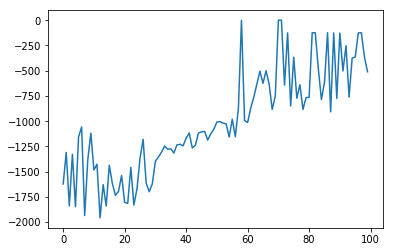

In [29]:
import matplotlib.pyplot as plt
plt.plot(eval_scores)